In [118]:
import gc

import pandas as pd

# 데이터경로

data_path = './competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path +'test.csv')
submission = pd.read_csv(data_path +'sample_submission.csv')

## 피처 엔지니어링 1 : 피처명 한글화

In [119]:
sales_train = sales_train.rename(columns = {'date' : '날짜' ,
                                            'date_block_num' : '월ID',
                                            'shop_id' : '상점ID',
                                            'item_id' : '상품ID',
                                            'item_price' : '판매가',
                                            'item_cnt_day' : '판매량'})

sales_train.head()

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [120]:
shops = shops.rename(columns = {'shop_name' : '상점명' ,
                              'shop_id' : '상점ID'})
shops.head()

,상점명,상점ID
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [121]:
items = items.rename(columns = {'item_name': '상품명',
                                'item_id' : '상품ID',
                                'item_category_id' : '상품분류ID'})

items.head()

,상품명,상품ID,상품분류ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [122]:
item_categories = item_categories.rename(columns = {'item_category_name' : '상품분류명',
                                                    'item_category_id' : '상품분류ID'})
item_categories.head()

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [123]:
test = test.rename(columns = {'shop_id' : '상점ID',
                              'item_id' : '상품ID'})
test.head()

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [124]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col] , downcast= 'integer')
        else:
            df[col] = pd.to_numeric(df[col] , downcast ='float')

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [125]:
all_df = [sales_train , shops , items , item_categories ,test]

for df in all_df:
    df= downcast(df)

62.5% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


In [126]:
sales_train.head()

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.000000,1
1,03.01.2013,0,25,2552,899.000000,1
2,05.01.2013,0,25,2552,899.000000,-1
3,06.01.2013,0,25,2554,1709.050049,1
4,15.01.2013,0,25,2555,1099.000000,1


## 피처 엔지니어링 3 : 데이터 조합 생성

In [127]:
from itertools import product
import numpy as np

train = []

# 월 ID , 상점 ID , 상품 ID 조합 생성
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID'] == i,  '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID'] == i , '상품ID'].unique()
    train.append(np.array(list(product([i] , all_shop , all_item))))

idx_features = ['월ID' , '상점ID' , '상품ID'] # 기준 피처

# 리스트 타입인 train을 DataFrame으로 변환

train = pd.DataFrame(np.vstack(train) , columns= idx_features)

train

,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913845,33,21,7635
10913846,33,21,7638
10913847,33,21,7640
10913848,33,21,7632


In [128]:
# idx_features를 기준으로 그룹화해 판매량 합 구하기

group = sales_train.groupby(idx_features).agg({'판매량' : 'sum'})

# 인덱스 재설정
group = group.reset_index()

# 피처명을 '판매량'에서 '월간 판매량'으로 변경
group = group.rename(columns = {'판매량' : '월간 판매량'})
group

,월ID,상점ID,상품ID,월간 판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1609119,33,59,22087,6
1609120,33,59,22088,2
1609121,33,59,22091,1
1609122,33,59,22100,1


In [129]:
# train과 group 병합하기

train = train.merge(group, on=idx_features , how = 'left')

train

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913845,33,21,7635,NaN
10913846,33,21,7638,NaN
10913847,33,21,7640,NaN
10913848,33,21,7632,NaN


In [130]:
test['월ID'] = 34

In [131]:
# train과 test 이어붙이기
all_data = pd.concat([train , test.drop('ID' , axis = 1)],
                     ignore_index= True, # 기존 인덱스 무시(0부터 새로 시작)
                     keys = idx_features) # 이어붙이는 기준이 되는 피처

In [132]:
all_data = all_data.fillna(0)

all_data

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
11128045,34,45,18454,0.0
11128046,34,45,16188,0.0
11128047,34,45,15757,0.0
11128048,34,45,19648,0.0


## 피처 엔지니어링 5 : 나머지 데이터 병합

In [133]:
# 나머지 데이터 병합

all_data = all_data.merge(shops , on = '상점ID' , how = 'left')
all_data = all_data.merge(items , on = '상품ID' , how = 'left')
all_data = all_data.merge(item_categories , on ='상품분류ID' , how = 'left')
all_data

,월ID,상점ID,상품ID,월간 판매량,상점명,상품명,상품분류ID,상품분류명
0,0,59,22154,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,59,2552,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,0,59,2554,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,0,59,2555,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,0,59,2564,0.0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео
...,...,...,...,...,...,...,...,...
11128045,34,45,18454,0.0,"Самара ТЦ ""ПаркХаус""",СБ. Союз 55,55,Музыка - CD локального производства
11128046,34,45,16188,0.0,"Самара ТЦ ""ПаркХаус""",Настольная игра Нано Кёрлинг,64,Подарки - Настольные игры
11128047,34,45,15757,0.0,"Самара ТЦ ""ПаркХаус""",НОВИКОВ АЛЕКСАНДР Новая коллекция,55,Музыка - CD локального производства
11128048,34,45,19648,0.0,"Самара ТЦ ""ПаркХаус""",ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,Кино - DVD


In [134]:
item_categories

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [135]:


# 데이터 다운캐스팅

all_data = downcast(all_data)

# 가비지 컬렉션

del shops, items, item_categories
gc.collect()

26.4% 압축됨


30

In [136]:
all_data.head()

,월ID,상점ID,상품ID,월간 판매량,상점명,상품명,상품분류ID,상품분류명
0,0,59,22154,1,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,59,2552,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,0,59,2554,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,0,59,2555,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,0,59,2564,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


In [137]:
all_data = all_data.drop(['상점명' , '상품명' , '상품분류명'] , axis =1 ) # 상점ID, 상품ID, 상품분류ID와 상점명,상품명,상품분류명과 매칭되므로 제거해도 된다.

all_data.head()

,월ID,상점ID,상품ID,월간 판매량,상품분류ID
0,0,59,22154,1,37
1,0,59,2552,0,58
2,0,59,2554,0,58
3,0,59,2555,0,56
4,0,59,2564,0,59


## 피처 엔지니어링 6

In [138]:
# 훈련 데이터(피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis =1)

# 검증 데이터(피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis = 1)

# 테스트 데이터(피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis = 1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID']<33]['월간 판매량']
y_train = y_train.clip(0,20) # 타깃값을 0~20으로 제한 , 하한값과 상한값을 잘라준다

# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] ==33]['월간 판매량']
y_valid = y_valid.clip(0,20)

In [139]:
X_train

,월ID,상점ID,상품ID,상품분류ID
0,0,59,22154,37
1,0,59,2552,58
2,0,59,2554,58
3,0,59,2555,56
4,0,59,2564,59
...,...,...,...,...
10675673,32,27,21279,61
10675674,32,27,21283,61
10675675,32,27,21352,37
10675676,32,27,21284,61


In [140]:
X_test

,월ID,상점ID,상품ID,상품분류ID
10913850,34,5,5037,19
10913851,34,5,5320,55
10913852,34,5,5233,19
10913853,34,5,5232,23
10913854,34,5,5268,20
...,...,...,...,...
11128045,34,45,18454,55
11128046,34,45,16188,64
11128047,34,45,15757,55
11128048,34,45,19648,40


In [141]:
X_valid

,월ID,상점ID,상품ID,상품분류ID
10675678,33,45,13315,47
10675679,33,45,13880,55
10675680,33,45,13881,55
10675681,33,45,13923,40
10675682,33,45,14227,30
...,...,...,...,...
10913845,33,21,7635,64
10913846,33,21,7638,64
10913847,33,21,7640,64
10913848,33,21,7632,64


In [142]:
y_train

0           1
1           0
2           0
3           0
4           0
           ..
10675673    0
10675674    0
10675675    0
10675676    0
10675677    0
Name: 월간 판매량, Length: 10675678, dtype: int16

In [143]:
y_valid

10675678    1
10675679    1
10675680    2
10675681    1
10675682    1
           ..
10913845    0
10913846    0
10913847    0
10913848    0
10913849    0
Name: 월간 판매량, Length: 238172, dtype: int16

In [144]:
del all_data
gc.collect()

# 가비지 컬렉션

90

## 모델 훈련 및 성능 검증

In [145]:
# 베이스라인 모델로 LightGBM을 사용한다. 기본 파라미터만 설정하고 LightGBM용 데이터셋을 만들어서 훈련한다.

# categorical_feature 파라미터에는 범주형 데이터를 전달하면 된다.

# 범주형 데이터로는 상점ID , 상품ID, 상품분류ID 가 있다.

# 이중 상품ID를 뺀 상점ID와 상품분류ID만 인수로 전달한다.

# 상품ID는 고윳값 개수가 상당히 많다. LightGBM은 고윳값 개수가 너무 많은 범주형 데이터는 수치형 데이터로 취급해야 성능이 더 좋다.

In [146]:
import lightgbm as lgb

# LightGBM 용 하이퍼파라미터

params = {'metric' : 'rmse', # 평가지표 = rmse
          'num_leaves' : 255, # 개별 트리가 가질수 있는 최대 말단 노드 개수
          'learning_rate' : 0.01, # 학습률(부스팅 이터레이션을 반복하면서 모델을 업데이트하는 데 사용 되는 비율)
          'force_col_wise' : True, # 메모리 용량이 충분하지 않을 때 메모리 효율을 높이는 파라미터
          'random_state'  : 10 # 랜덤 시드값(코드를 반복 실행해도 같은 결과가 나오게 지정하는 값)
          }

# 범주형 피처 설정
cat_features = ['상점ID' , '상품분류ID']

# LightGBM용 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train,  y_train) # LightGBM 전용 훈련 데이터 셋
dvalid = lgb.Dataset(X_valid , y_valid) # LightGBM 전용 검증 데이터 셋

# LightGBM 모델 훈련

lgb_model = lgb.train(params = params, # 훈련용 데이터
                      train_set= dtrain, # 훈련 데이터 셋
                      num_boost_round= 500, # 부스팅 반복 횟수
                      valid_sets= (dtrain , dvalid), # 성능 평가용 검증 데이터 셋
                      categorical_feature= cat_features , # 범주형 데이터 파라미터, 이 파라미터에 전달된 데이터를 범주형 데이터로 인식한다.
                      verbose_eval= 50)# 50번째 마다 점수 출력

C:\Users\andyp\anaconda3\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['상점ID', '상품분류ID']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\andyp\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 10675678, number of used features: 4
[LightGBM] [Info] Start training from score 0.299125


C:\Users\andyp\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\andyp\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	training's rmse: 1.14777	valid_1's rmse: 1.06755
[100]	training's rmse: 1.11425	valid_1's rmse: 1.0386
[150]	training's rmse: 1.09673	valid_1's rmse: 1.02671
[200]	training's rmse: 1.08573	valid_1's rmse: 1.02027
[250]	training's rmse: 1.07722	valid_1's rmse: 1.01661
[300]	training's rmse: 1.0698	valid_1's rmse: 1.0138
[350]	training's rmse: 1.06317	valid_1's rmse: 1.01084
[400]	training's rmse: 1.05734	valid_1's rmse: 1.00936
[450]	training's rmse: 1.05224	valid_1's rmse: 1.00818
[500]	training's rmse: 1.04792	valid_1's rmse: 1.00722


In [147]:
preds = lgb_model.predict(X_test).clip(0 ,20) # 테스트 데이터를 활용해 타깃값을 예측해보면 타깃값은 0~20 사이의 값이어야 하므로 예측한 값도 clip() 함수로 범위를 제한하였다.

# 제출 파일 생성

submission['item_cnt_month'] = preds

submission

,ID,item_cnt_month
0,0,0.582913
1,1,0.356839
2,2,0.427943
3,3,0.401808
4,4,0.569875
...,...,...
214195,214195,0.116547
214196,214196,0.127952
214197,214197,0.116827
214198,214198,0.098552


In [148]:
preds = lgb_model.predict(X_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission_1.csv' , index = False)

submission

,ID,item_cnt_month
0,0,0.582913
1,1,0.356839
2,2,0.427943
3,3,0.401808
4,4,0.569875
...,...,...
214195,214195,0.116547
214196,214196,0.127952
214197,214197,0.116827
214198,214198,0.098552


In [149]:
del X_train, y_train , X_valid , y_valid , X_test , lgb_model , dtrain , dvalid

gc.collect()

361

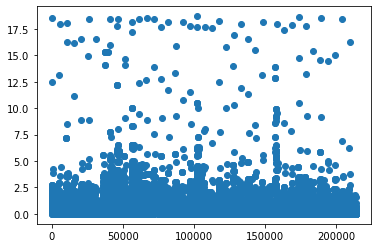

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter( submission['ID'] , submission['item_cnt_month'] )